# 1. Baseline
classify for math and relax in synchronized_brainwave_dataset data

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
import tsgm
from tsgm.models.architectures.zoo import zoo  
from tensorflow.keras.utils import to_categorical
import ast
%matplotlib inline

In [2]:
X, y = tsgm.utils.get_synchronized_brainwave_dataset()
print('feature shape in total data:',X.shape)
print('label shape in total data:',y.shape)

INFO:utils:File exist


feature shape in total data: (30013, 12)
label shape in total data: (30013,)


In [3]:
df = pd.read_csv("../data/synchronized_brainwave_dataset.csv")

In [4]:
# we want to classify label 'relax' and 'math'
relax = df[df.label == 'relax']
math = df[(df.label == 'math1') |
          (df.label == 'math2') |
          (df.label == 'math3') |
          (df.label == 'math4') |
          (df.label == 'math5') |
          (df.label == 'math6') |
          (df.label == 'math7') |
          (df.label == 'math8') |
          (df.label == 'math9') |
          (df.label == 'math10') |
          (df.label == 'math11') |
          (df.label == 'math12') ]

print('length of relax data:',len(relax))
print('length of math data',len(math))

length of relax data: 934
length of math data 936


In [5]:
relax_math = pd.concat([relax, math], axis=0)

In [6]:
relax_math['raw_values'] = relax_math['raw_values'].apply(ast.literal_eval)

In [7]:
# A signal values over 128 indicate that the headset was placed incorrectly.
relax_math = relax_math[relax_math['signal_quality'] < 128]

relax_math['label'] = relax_math['label'].str.replace(r'^math.*$', 'math', regex=True)

relax_math['raw_values'] = relax_math['raw_values'].apply(lambda x: np.array(x, dtype=float))

# Ensure all arrays have the same length
max_len = max(relax_math['raw_values'].apply(len))
relax_math['raw_values'] = relax_math['raw_values'].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant') if len(x) < max_len else x)

label_encoder = LabelEncoder()
relax_math['label'] = label_encoder.fit_transform(relax_math['label'])

features_matrix = np.stack(relax_math['raw_values'].values)

In [8]:
# we choose column 'raw_values' as our feature for label
X = features_matrix
y = relax_math['label']

In [9]:
# print('data shape:', relax_math.shape)
print('feature shape:', X.shape)
print('label shape:', y.shape)
# print(X.head())

feature shape: (1870, 512)
label shape: (1870,)


In [10]:
# features_matrix

In [11]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## 1.2 Time series model

In [12]:
seq_len = 8  # Number of timesteps per sequence
feat_dim = 64  # Number of features per timestep
output_dim = 2  # Number of output classes

X_train_ts = X_train.reshape(-1, seq_len, feat_dim) 
X_val_ts = X_val.reshape(-1, seq_len, feat_dim)

model_ts_architecture = zoo['clf_cn'](seq_len, feat_dim, output_dim)
model_ts = model_ts_architecture.model

model_ts.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)


In [13]:
# Model training
history_ts = model_ts.fit(
    X_train_ts, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_ts, y_val),
    verbose=0
)

In [14]:
val_loss_ts, val_acc_ts = model_ts.evaluate(X_val_ts, y_val)
print('val loss in ts model:', val_loss_ts)
print("val accuracy in ts model:", val_acc_ts)

12/12 [==============================] - 0s 643us/step - loss: 2.0502 - accuracy: 0.6016
val loss in ts model: 2.050161123275757
val accuracy in ts model: 0.6016042828559875


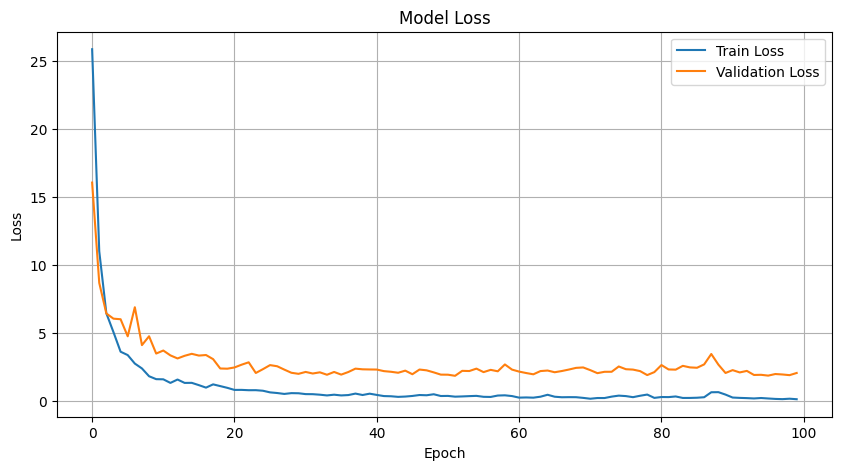

In [15]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history_ts.history['loss'], label='Train Loss')
plt.plot(history_ts.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

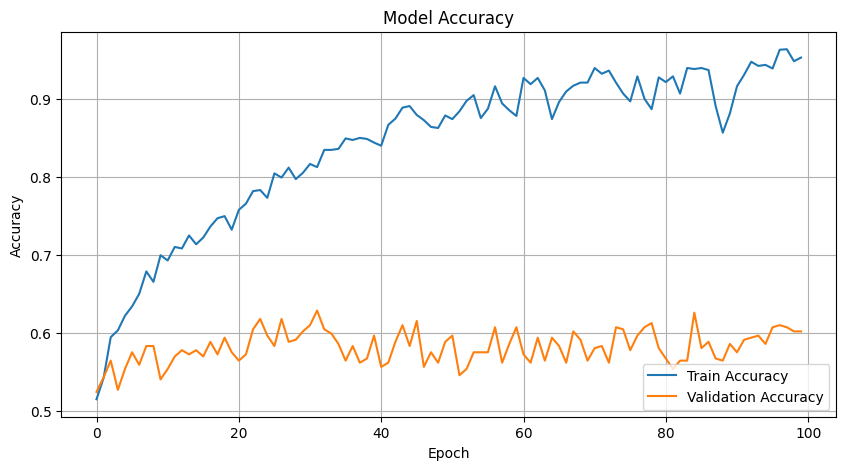

In [16]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history_ts.history['accuracy'], label='Train Accuracy')
plt.plot(history_ts.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## 1.3 Sequential model

In [17]:
model = Sequential([
    Dense(10, activation='relu', input_shape=(max_len,)),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              # loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [18]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=0
)

In [19]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print('val loss in normal model:', val_loss)
print("val accuracy in normal model:", val_acc)

12/12 [==============================] - 0s 472us/step - loss: 2.2675 - accuracy: 0.4973
val loss in normal model: 2.267547845840454
val accuracy in normal model: 0.49732619524002075


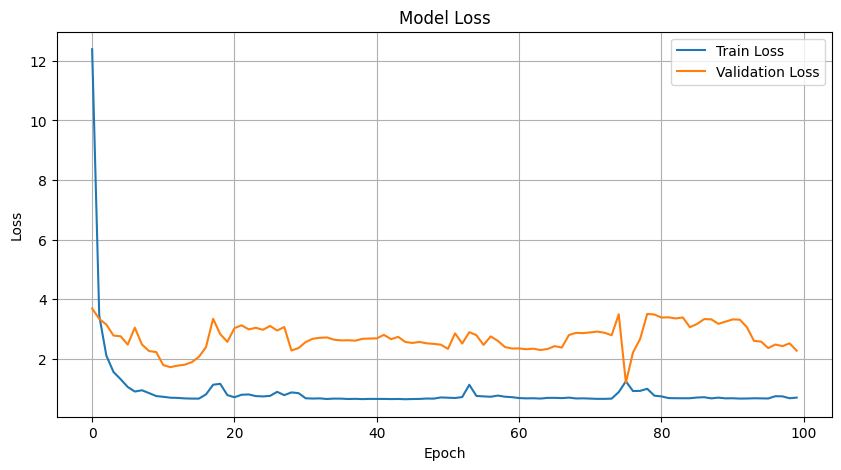

In [20]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

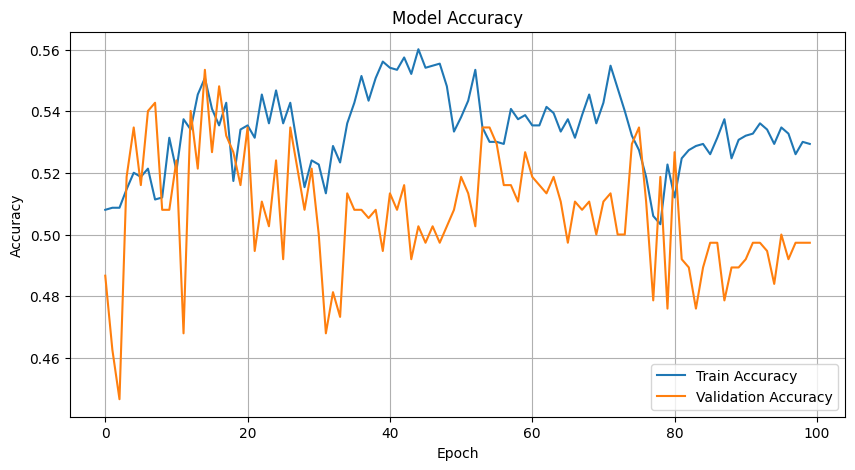

In [21]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 2. Augmentations

augment X_train_ts and y_train using GAN

In [22]:
seq_len = 8
feat_dim = 64
batch_size = 128

# generator_in_channels = latent_dim + output_dim
# discriminator_in_channels = feature_dim + output_dim

In [35]:
print(X_train_ts.shape)
print(type(X_train_ts))

(1496, 8, 64)
<class 'numpy.ndarray'>


In [38]:
from sklearn.preprocessing import MinMaxScaler
# todo: do we need to scale X??
X_min = X_train_ts.min(axis=(0, 1), keepdims=True)
X_max = X_train_ts.max(axis=(0, 1), keepdims=True)

X_train_ts_scaled = 2 * ((X_train_ts - X_min) / (X_max - X_min)) - 1

# scaler = MinMaxScaler(feature_range=(-1, 1))
# X_train_ts_scaler = np.stack(X_train_ts.apply(lambda x: scaler.fit_transform(x.reshape(-1, 1)).flatten()))
X_train_ts_scaled_32 = X_train_ts_scaled.astype(np.float32)
y_train_32 = y_train.astype(np.float32)
y_train_onehot_32 = to_categorical(y_train, num_classes=output_dim)

In [39]:
print(X_train_ts_scaled_32.shape)
print(y_train_onehot_32.shape)

(1496, 8, 64)
(1496, 2)


In [25]:
# adjust its shape to series
# X_np = X.to_numpy() 
# X_ts = X_np.reshape(-1, seq_len, feat_dim) 
# X_ts.shape

# scaler = MinMaxScaler(feature_range=(-1, 1))
# X = np.stack(relax_math['raw_values'].apply(lambda x: scaler.fit_transform(x.reshape(-1, 1)).flatten()))
# y = keras.utils.to_categorical(relax_math['label'], num_classes=2)

# scaler = tsgm.utils.TSFeatureWiseScaler((-1, 1))
# X_train = scaler.fit_transform(X_train_ts_32)


In [40]:
dataset = tf.data.Dataset.from_tensor_slices((X_train_ts_scaled_32, y_train_onehot_32))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

In [41]:
latent_dim = 64
output_dim = 2

architecture = tsgm.models.architectures.zoo["cgan_base_c4_l1"](
    seq_len=seq_len, feat_dim=feat_dim,
    latent_dim=latent_dim, output_dim=output_dim)
discriminator, generator = architecture.discriminator, architecture.generator

In [42]:
cond_gan = tsgm.models.cgan.ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.legacy.Adam(learning_rate=0.02, beta_1=0.5),
    g_optimizer=keras.optimizers.legacy.Adam(learning_rate=0.02, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

In [43]:
import warnings
warnings.filterwarnings('ignore')

In [44]:
cbk = tsgm.models.monitors.GANMonitor(num_samples=3, latent_dim=latent_dim, save=False, labels=y_train_onehot_32, save_path="./tmp")
cond_gan.fit(dataset, epochs=5, callbacks=[cbk], verbose=0)

In [45]:
print(y_train_onehot_32[:5])



[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [47]:
limit = 5
X_gen = cond_gan.generate(y_train_onehot_32[:limit])
X_gen = X_gen.numpy()
y_gen = y[:limit]
print(X_gen[1])


[[-0.99999976  0.9996441   0.9947663   0.9985018  -0.99605376  0.9999972
  -0.9999939  -0.9994647  -0.9998888  -0.9967149  -0.99874616 -0.9999729
  -0.9999519  -0.99992204  0.9999877   0.99847806  0.99726915  0.99867976
  -0.9999949   0.99938124 -0.99927175 -0.9909994  -0.9868546  -0.9997206
  -0.9999986  -0.9997139  -0.99998975  0.9965205   0.9982372  -0.9979722
   0.9957258   0.99986047 -0.99990445  0.99999    -0.99997604 -0.9996386
  -0.9981849   0.9999987   0.97191584 -0.99948037  0.99991816  0.9999658
   0.99961644  0.99980754 -0.99975014 -0.9995929  -0.99996126  0.998848
   0.9361116  -0.99990314 -0.9962934   0.9975584  -0.99999976 -0.9999932
   0.9949587  -0.99999255  0.99976283 -0.9999991  -0.99899447 -0.9999977
  -0.99929804 -0.9874998  -0.999999    0.9947624 ]
 [-0.9999968   0.9982716  -0.9999986  -0.99999636 -0.99999976  0.9995329
  -0.9999988  -0.9999957  -0.99999404  0.99926263 -0.9999935  -0.99999976
  -0.99999535 -0.9999989  -0.9995394   0.9999867   0.9990056  -0.9999997